In [2]:
import gdown

In [ ]:
#Данные с моего гугл диска (Отредактированный Tacotron2 и чекпоинт Tacotron2 c ParalellWaveGan)
url = 'https://drive.google.com/uc?id=16lRrfX8gT9SpZNgj0SOIFUaqfixUbd4w'
output = 'Tacotron2.7z'
gdown.download(url, output, quiet=False)
!7z x Tacotron2.7z
!rm Tacotron2.7z

#Грузим с гита G2P
!git clone https://github.com/nsu-ai/russian_g2p.git/
!cp -R /content/russian_g2p/russian_g2p /content/

In [ ]:
!pip install numpy==1.20.2
!pip install matplotlib==3.0.2
!pip install tensorflow==1.15.2
!pip install inflect==0.2.5
!pip install librosa==0.8.0
!pip install scipy==1.4.1
!pip install Unidecode==1.0.22 
!pip install Pillow
!pip install PyYAML==5.4.1
!pip install parallel_wavegan==0.5.3
!pip install lxml
!pip install DAWG
!pip install git+https://github.com/bond005/rnnmorph.git
!pip install keras==2.3.1
!pip install 'h5py==2.10.0' --force-reinstall

In [1]:
#Зависимости
import sys
import IPython.display as ipd
import torch
import numpy as np
import yaml
import matplotlib.pyplot as plt
import re
import os

#Акустическая модель
sys.path.append("/content/Tacotron2")
from Tacotron2.hparams import create_hparams
from Tacotron2.model import Tacotron2
from Tacotron2.text import text_to_sequence

#Вокодер
from parallel_wavegan.utils import load_model

#G2P
sys.path.append("/content/russian_g2p/")
from russian_g2p.Accentor import Accentor
from russian_g2p.Transcription import Transcription

Using TensorFlow backend.


На данный момент я обучил акустическую модель Tacotron2, вокодер PWG, на датасете RUSLAN с использованием G2P

Tacotron 2 - https://github.com/NVIDIA/tacotron2

PWG - ParallelWavegan - https://github.com/kan-bayashi/ParallelWaveGAN

G2P - https://github.com/nsu-ai/russian_g2p

Датасет RUSLAN - Russian Spoken Language Corpus For Speech Synthesis - https://ruslan-corpus.github.io/

Результат обработки датасета руслан при помощи G2P можно увидеть в файле /content/Tacotron2/filelists/train.csv и /content/Tacotron2/filelists/val.csv .Чтоб новые символы из ARPABET алфавита понимались пришлось отредактировать файл /content/Tacotron2/text/cmudict.py, а русский буквы в /content/Tacotron2/text/symbols.py

In [2]:
#Функция для отображения спектограммы и линии внимания
def plot_data(data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], 
                       aspect='auto', 
                       #origin='bottom',
                       interpolation='none')

In [3]:
#Функция возвращает транскрипцию G2P в немного модифицированном виде - оставляет знаки препинания (точки, запятые и пробелы).
def getTranscript(text, transcriptor):
    #Убираем все символы кроме букв и знаков . , ! ? -
    normText = str.lower(text) 
    normText = normText.replace('(', '')
    normText = normText.replace(')', '')
    normText = normText.replace(' - ', ' ')
    normText = normText.replace("'", "")
    normText = normText.replace("'", "")
    normText = re.sub("[^А-Яа-яЁё|\s|.|!|?|,|'-|+|…]", "", normText)
    #убираем двойные знаки
    normText = normText.replace('!..', '!')
    normText = normText.replace('?..', '?')
    normText = normText.replace('...', '.')
    normText = normText.replace('..', '.')
    #добавляем пробелы между допустимыми символами
    normText = normText.replace(',', ' , ')
    normText = normText.replace('.', ' . ')
    normText = normText.replace('?', ' ? ')
    normText = normText.replace('!', ' ! ')
    normText = normText.replace('…', ' … ')
    #На всякий случае убираем дублированные пробелы
    normText = normText.replace('    ', ' ')
    normText = normText.replace('   ', ' ')
    normText = normText.replace('  ', ' ')
    
    #Список слов разделённых по пробелу
    text_list = normText.split()
               
    #Строка подающаяся в транскриптор
    accntText = ''
    for word in text_list:
        if word not in('.', ',', '!', '?', '…'):
            accntText += word + '<sil>'
    
    #Массив фонем
    transcriptText = transcriptor.transcribe([accntText])
    
    #Из фонем лепим слова
    transcript_list = []
    for i in range(len(transcriptText[0])):
        temp = '{'
        for alf in transcriptText[0][i]:
            temp += alf + ' '
        temp += '}'
        transcript_list.append(temp)
        
    #Ставим обратно знаки препинания
    for i in range(len(text_list)):
        if(text_list[i]) in ('.', ',', '!', '?', '…'):
            transcript_list.insert(i, text_list[i])
    
    rezult = ''
    for word in transcript_list:
        rezult += word
    
    rezult = rezult.replace(',', ', ')
    rezult = rezult.replace('.', '. ')
    rezult = rezult.replace('!', '! ')
    rezult = rezult.replace('?', '? ')
    rezult = rezult.replace('…', '… ')
    rezult = rezult.replace('}{', '} {')

    
    return rezult

Загружаем акустическую модель и вокодер из чекпоинтов

In [4]:
#ВОКОДЕР PWG

configPWG_dir= "/content/Tacotron2/pretrainPWG/config.yml"
stats_dir = "/content/Tacotron2/pretrainPWG/stats.h5"
checkpointPWG_dir = "/content/Tacotron2/pretrainPWG/checkpoint-400000steps.pkl" 

with open(configPWG_dir) as f:
    configPWG = yaml.load(f, Loader=yaml.Loader)
    
model_parallel_wavegan = load_model(checkpointPWG_dir, configPWG)
_ = model_parallel_wavegan.cpu().eval() 

In [5]:
#АКУСТИЧЕСКАЯ МОДЕЛЬ Tacotron2

hparams = create_hparams()
checkpointTaco_dir = "/content/Tacotron2/data/checkpoints/checkpoint_100000"
model = Tacotron2(hparams)
model.load_state_dict(torch.load(checkpointTaco_dir, map_location=torch.device('cpu'))['state_dict'])
#_ = model.cuda().eval()
_ = model.cpu().eval()

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



Демонстрация того что теперь можно управлять удареием в словах + ставить паузы используя символ точки

In [25]:
your_transcriptor = Transcription()

#Правильное ударение
print('Правильное ударение:')
text1 = getTranscript('Те+ст маги+стерской рабо+ты, Евге+ния Уса+нова.', your_transcriptor) 
print(text1)
sequence1 = np.array(text_to_sequence(text1, ['basic_cleaners']))[None, :]
print(sequence1)
sequence1 = torch.autograd.Variable(torch.from_numpy(sequence1)).cpu().long()
print('--------------------------')

#Неправильное ударение
print('Не правильное ударение:')
text2 = getTranscript('Те+ст магисте+рской ра+боты, Евгени+я Усано+ва.', your_transcriptor)
print(text2)
sequence2 = np.array(text_to_sequence(text2, ['basic_cleaners']))[None, :]
print(sequence2)
sequence2 = torch.autograd.Variable(torch.from_numpy(sequence2)).cpu().long()
print('--------------------------')

#Пауза между словами
print('Пауза между словами:')
text3 = getTranscript('Евге+ний . . . Уса+нов.', your_transcriptor)
print(text3)
sequence3 = np.array(text_to_sequence(text3, ['basic_cleaners']))[None, :]
print(sequence3)
sequence3 = torch.autograd.Variable(torch.from_numpy(sequence3)).cpu().long()
print('--------------------------')

Правильное ударение:
{T E0 S T } {M A G0 I0 S0 T0 I R S K A J0 } {R A B O0 T Y }, {J0 I V G0 E0 N0 I J0 A } {U S A0 N A V A }. 
[[ 99 116  95  99   6  87  73  82 112  96 100 111  93  95  83  73 110   6
   93  73  75 114  99 103   3   6 110 111 101  82 116  90 111 110  73   6
  129  95  74  89  73 101  73   4   6]]
--------------------------
Не правильное ударение:
{T E0 S T } {M A G0 I S0 T0 E0 R S K A J0 } {R A0 B A T Y }, {J0 I V G0 I N0 I0 J0 A } {U S A N O0 V A }. 
[[ 99 116  95  99   6  87  73  82 111  96 100 116  93  95  83  73 110   6
   93  74  75  73  99 103   3   6 110 111 101  82 111  90 112 110  73   6
  129  95  73  89 114 101  73   4   6]]
--------------------------
Пауза между словами:
{J0 I V G0 E0 N0 I J0 }. . . {U S A0 N A F }. 
[[110 111 101  82 116  90 111 110   4   6   4   6   4   6 129  95  74  89
   73  79   4   6]]
--------------------------


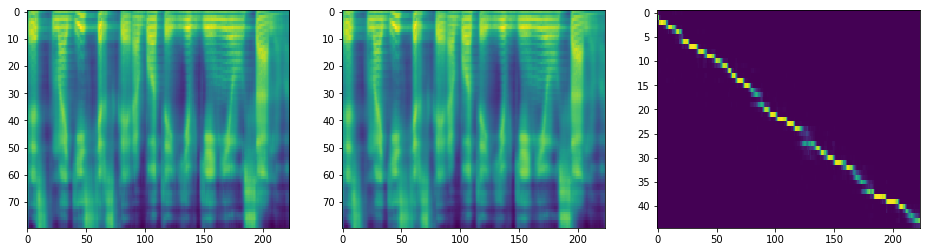

In [26]:
#Правильное ударение
mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence1)
    
plot_data((mel_outputs.float().data.cpu().numpy()[0],
           mel_outputs_postnet.float().data.cpu().numpy()[0],
           alignments.float().data.cpu().numpy()[0].T))

melTact = mel_outputs_postnet.cpu().detach()[0]
melTact = melTact.T

y = model_parallel_wavegan.inference(melTact, normalize_before=True).view(-1)

ipd.Audio(y.detach().numpy(), rate=hparams.sampling_rate)

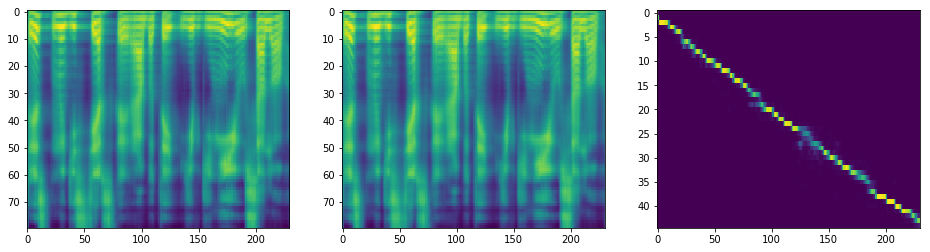

In [27]:
#Ударение не в том месте
mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence2)
    
plot_data((mel_outputs.float().data.cpu().numpy()[0],
           mel_outputs_postnet.float().data.cpu().numpy()[0],
           alignments.float().data.cpu().numpy()[0].T))

melTact = mel_outputs_postnet.cpu().detach()[0]
melTact = melTact.T

y = model_parallel_wavegan.inference(melTact, normalize_before=True).view(-1)

ipd.Audio(y.detach().numpy(), rate=hparams.sampling_rate)

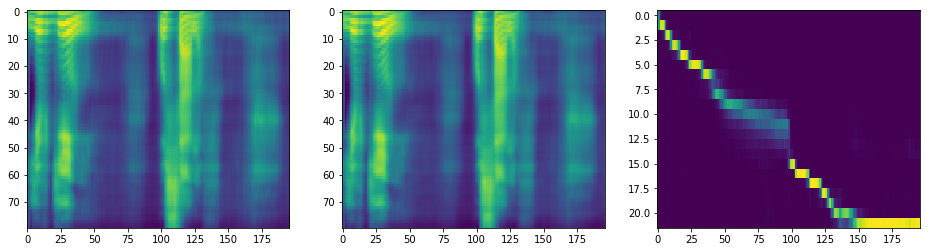

In [28]:
#Вставка паузы
mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence3)
    
plot_data((mel_outputs.float().data.cpu().numpy()[0],
           mel_outputs_postnet.float().data.cpu().numpy()[0],
           alignments.float().data.cpu().numpy()[0].T))

melTact = mel_outputs_postnet.cpu().detach()[0]
melTact = melTact.T

y = model_parallel_wavegan.inference(melTact, normalize_before=True).view(-1)

ipd.Audio(y.detach().numpy(), rate=hparams.sampling_rate)

Что я планирую изменить:

1) Заменить Tacotron2 на Mellotron, реализация его лежит вот тут - https://github.com/NVIDIA/mellotron. Это позволит обучать акустическую систему под несколько голосов, плюс позволяет передавать эмоции. В основе mellotron лежит статья Tacotron GST - Global Style Token, суть в том что берется референсная дорожка с которой планируется взять эмоцию, создается вектор признаков по реф. дорожке, а потом этот вектор признаков накладывается на генерируемую дрожку. Статья Tacotron GST вот - https://arxiv.org/pdf/1803.09017.pdf . Развитие идеи Mellotron статья вот - https://arxiv.org/pdf/1910.11997.pdf

2) Датасет RUSLAN теперь плохо подходит для обучения, ведь там всего один голос, и говорит он всегда ровно, с одной эмоцией. Я решил эту проблему тем что создаю новый датасет. Я смог разархивировать файлы озвучки игры Cyberpunk 2077. Файлы озвучки я вытащил вот с помощью этого видео на ютубе: https://youtu.be/B-PaWH6PQfc . Субтитры можно достать из json файлов игры только их предварительно пришлось расшифровывать программой CP77 MODDING TOOLS . Я могу скинуть свой скрипт на python который из файлов игры создал датасет обучения если это важно для работы. В результате получилось 8.5 часов речи главного героя мужчины, 8.5 часов речи главного героя женщины, и еще по 1.5 часа речи 5 сторостепенных героев. Датасет я еще не закончил проверять, но как закончу могу выложить в свободный доступ. Это уникальный датасет - речь чистая, несколько голосов и очень много эмоциональных фраз. Такого я нигде не нашёл в свободном доступе. Плюсь я еще могу достать озвучку из игры Ведьмак 3 - там практически точно такая же структура файлов, но не думаю что это нужно. И так довольно много получается материала.

3) Заменю вокодер ParallelWaveGAN на HIFI-GAN - ссылка вот https://github.com/rishikksh20/HiFi-GAN

4) В качестве обучающего материала я смотрел лекции и практики от МФТИ. Лекция по акустическим моделям - https://youtu.be/bXzJPOt-XxA . Лекция по Вокодерам - https://youtu.be/wDmsmtlqb1s . Там много материала и картинок, думаю много можно перенести в диплом после обработки.